In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from config import config
from torch.utils.data import DataLoader
from dataset.dataset import BloomDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns
# utils
import torch

# models
import torch.nn as nn

# training and evaluation
import wandb
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.optim as optim
import geoopt
from sklearn.metrics import accuracy_score, f1_score
from models.baselines.LSTM import LSTMClassifier
from models.baselines.RoBERTa import RoBERTaClassifier
# from models.baselines.DistilRoBERTa import DistilRoBERTaClassifier
from models.baselines.LSTMAttn import LSTMAttnClassifier
from models.baselines.CNN import CNNClassifier
from models.baselines.VDCNN import VDCNNClassifier
from models.baselines.RCNN import RCNNClassifier
from models.baselines.SelfAttn import SelfAttnClassifier
from models.baselines.Seq2SeqAttn import Seq2SeqAttnClassifier
from models.baselines.HAN import HANClassifier
from models.BloomNet import BloomNetClassifier
from models.Bloomnet_han_ling import BloomNet2Classifier
# from models.model import Model

In [2]:
sns.set_style("darkgrid")

In [3]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base', usefast=True, use_lower_case=True)
# loaders = get_loaders(tokenizer=tokenizer, config=config['data'])

In [4]:
def get_loaders(tokenizer, config):
    
    path_1 = os.path.join(os.getcwd(), "data", "BloomTaxonomy.csv")
    path_2 = os.path.join(os.getcwd(), "data", "BloomTaxonomy2.csv")
    
    dataset1 = BloomDataset(
        tokenizer=tokenizer,
        file_name=path_1,
        text_field=config['Text'], 
        label_field=config['Label'], 
        max_len=config['max_len']
    )
    
    dataset2 = BloomDataset(
        tokenizer=tokenizer,
        file_name=path_2,
        text_field=config['Text'], 
        label_field=config['Label'], 
        max_len=config['max_len']
    )
    
    # create dataset2 loader
    
    loader2 = DataLoader(dataset=dataset2, batch_size=config['batch_size'], shuffle=False,        num_workers=config['num_workers'])

    loader1 = DataLoader(dataset=dataset1, batch_size=config['batch_size'], shuffle=False,        num_workers=config['num_workers'])

    return loader1, loader2





In [5]:
loader1, loader2 = get_loaders(tokenizer=tokenizer, config=config['data'])

Using custom data configuration default-0f07672984e5d615
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-0f07672984e5d615/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
Using custom data configuration default-873e9b92bfa129e8
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-873e9b92bfa129e8/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [6]:
print(len(loader1), len(loader2))

150 36


In [7]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig

In [8]:
class DistilRoBERTaClassifier(nn.Module):

    def __init__(self, model_name="distilroberta-base", num_classes=6):
        super(DistilRoBERTaClassifier, self).__init__()
        
        # pretrained transformer model as base
        self.base = AutoModel.from_pretrained(pretrained_model_name_or_path=model_name)
        
        

        # nn classifier on top of base model
        self.classifier = nn.Sequential(*[
            nn.Linear(in_features=768, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=num_classes),
        ])

    def forward(self, input_ids, attention_mask=None, _len=None):

        # last hidden states
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
        
        # cls token from last hidden states
        pooler = outputs[0][:, 0]

        # pass it to nn classifier
        logits = self.classifier(pooler)


        return logits, pooler

In [9]:

class LightningModel(pl.LightningModule):

    def __init__(self, model_name, vocab_size, config):

        super(LightningModel, self).__init__()

        self.config = config
        self.model_name = model_name
        
        if model_name == "model" or model_name=="bloomnet" or model_name == None:
            self.model = BloomNetClassifier(
                model_name="roberta-base",
                num_classes=config['data']['num_classes'],
                max_len=config['data']['max_len'],
                fusion=config['model']['fusion'],
            )
        elif model_name == "bloomnet2" or model_name == "model2":
            self.model = BloomNet2Classifier(
                vocab_size=vocab_size,
            )

        # joint model

        elif model_name == "han":
            self.model = HANClassifier(
                num_classes=config['data']['num_classes'],
                vocab_size=vocab_size,
                embed_dim=config['model']['hidden_size'],
                word_gru_hidden_dim=config['model']['hidden_size'],
                sent_gru_hidden_dim=config['model']['hidden_size'],
                word_gru_num_layers=config['model']['num_layers'],
                sent_gru_num_layers=config['model']['num_layers'],
                word_att_dim=config['model']['hidden_size'],
                sent_att_dim=config['model']['hidden_size'],
                use_layer_norm=True,
                dropout=config['model']['dropout']

            )

        elif model_name == 'lstm':
            
            self.model = LSTMClassifier(
                vocab_size=vocab_size,
                hidden_size=config['model']['hidden_size'],
                num_layers=config['model']['num_layers'],
            )
            
        elif model_name == 'lstm_attn':
            self.model = LSTMAttnClassifier(
                vocab_size=vocab_size
            )
        elif model_name == 'rcnn':
            self.model = RCNNClassifier(
                vocab_size=vocab_size,
                batch_size=config['data']['batch_size'], 
                output_size=config['data']['num_classes'], 
                hidden_size=config['model']['hidden_size'], 
                embedding_length=config['model']['hidden_size'],  
            )
        elif model_name == "cnn":
            self.model = CNNClassifier(
                vocab_size=vocab_size,
            )
        elif model_name == "vdcnn":
            self.model = VDCNNClassifier(
                vocab_size=vocab_size,
                hidden_size=config['model']['hidden_size'],
                num_classes=config['data']['num_classes']
            )
            
        elif model_name == "self_attn":
            self.model = SelfAttnClassifier(
                vocab_size=vocab_size,
                hidden_size=config['model']['hidden_size'],
                num_classes=config['data']['num_classes']
            )
            
        elif model_name == "seq2seq_attn":
            self.model = Seq2SeqAttnClassifier(
                vocab_size=vocab_size,
                hidden_size=config['model']['hidden_size'],
                bidirectional=config['model']['bidirectional'],
                num_layers=config['model']['num_layers'],
                dropout=config['model']['dropout'],
                num_classes=config['data']['num_classes'],
            )
        elif model_name=="roberta-base":
            self.model = RoBERTaClassifier()
            
        elif model_name=="distilroberta-base":
            
            self.model = DistilRoBERTaClassifier()
            
        else:
            self.model = RoBERTaClassifier()
            


    def forward(self, input_ids, attention_mask=None, _len=None):
        logits, pooler  = self.model(input_ids=input_ids, attention_mask=attention_mask, _len=_len)
        return logits, pooler

    def configure_optimizers(self):
        # euclidean optimizer vs HyRNN
        if self.model_name == "model" or self.model_name=="hyp" or self.model_name == "hyrnn":
            return geoopt.optim.RiemannianAdam(
                self.parameters(),
                lr=self.config['training']['lr'],
                stabilize=10,
            )
        else: return optim.AdamW(params=self.parameters(), lr=self.config['training']['lr'])

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['target'].squeeze()
        logits, _ = self(input_ids=input_ids, attention_mask=attention_mask, _len=batch['_len'])
        loss = F.cross_entropy(logits, targets)
        acc = accuracy_score(targets.cpu(), logits.argmax(dim=-1).cpu())
        f1 = f1_score(targets.cpu(), logits.argmax(dim=-1).cpu(), average=self.config['training']['average'])
        wandb.log({"loss":loss, "accuracy":acc, "f1":f1})
        return {"loss":loss, "accuracy":acc, "f1":f1}

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['target'].squeeze()
        logits, _ = self(input_ids=input_ids, attention_mask=attention_mask, _len=batch['_len'])
        loss = F.cross_entropy(logits, targets)
        acc = accuracy_score(targets.cpu(), logits.argmax(dim=-1).cpu())
        f1 = f1_score(targets.cpu(), logits.argmax(dim=-1).cpu(), average=self.config['training']['average'])
        wandb.log({"val_loss":loss, "val_accuracy":torch.tensor([acc]), "val_f1":torch.tensor([f1])})
        return {"val_loss":loss, "val_accuracy":torch.tensor([acc]), "val_f1":torch.tensor([f1])}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_accuracy'] for x in outputs]).mean()
        avg_f1 = torch.stack([x['val_f1'] for x in outputs]).mean()
        return {"val_loss":avg_loss, "val_accuracy":avg_acc, "val_f1":avg_f1,}

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['target'].squeeze()
        logits, _ = self(input_ids=input_ids, attention_mask=attention_mask, _len=batch['_len'])
        loss = F.cross_entropy(logits, targets)
        acc = accuracy_score(targets.cpu(), logits.argmax(dim=-1).cpu())
        f1 = f1_score(targets.cpu(), logits.argmax(dim=-1).cpu(), average=self.config['training']['average'])
        return {"test_loss":loss, "test_accuracy":torch.tensor([acc]), "test_f1":torch.tensor([f1])}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_accuracy'] for x in outputs]).mean()
        avg_f1 = torch.stack([x['test_f1'] for x in outputs]).mean()
        return {"test_loss":avg_loss, "test_accuracy":avg_acc, "test_f1":avg_f1}

In [10]:
model = LightningModel(model_name="distilroberta-base", vocab_size=tokenizer.vocab_size, config=config)

In [11]:
model.load_state_dict(torch.load("/home/macab/research/BloomNet/Checkpoints/distilroberta-base/fold0/epoch=8.ckpt", map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [12]:
# model.forward?

In [13]:
pretrained = AutoModel.from_pretrained('distilroberta-base')

In [14]:
for param in model.parameters():
    param.requires_grad = False
for param in pretrained.parameters():
    param.requires_grad = False

In [15]:
# model.forward?

In [16]:
rep_data1 = torch.empty((0, 768))
rep_data1_pretrained = torch.empty((0, 768))

for batch in tqdm(loader1):

    _, pooler = model.model.forward(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

    out = pretrained(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])[0][:, 0]

    rep_data1 = torch.vstack((rep_data1, pooler))
    rep_data1_pretrained = torch.vstack((rep_data1_pretrained, out))



rep_data2 = torch.empty((0, 768))
rep_data2_pretrained = torch.empty((0, 768))

for batch in tqdm(loader2):
    _, pooler = model.model.forward(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

    out = pretrained(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])[0][:, 0]

    rep_data2 = torch.vstack((rep_data2, pooler))

    rep_data2_pretrained = torch.vstack((rep_data2_pretrained, out))

    # break


100%|██████████| 36/36 [00:08<00:00,  4.43it/s]


In [18]:
print(rep_data1.shape, rep_data2.shape, rep_data1_pretrained.shape, rep_data2_pretrained.shape)

torch.Size([600, 768]) torch.Size([141, 768]) torch.Size([600, 768]) torch.Size([141, 768])


In [19]:
x =  np.vstack((rep_data1.numpy(), rep_data2.numpy(), rep_data1_pretrained.numpy(), rep_data2_pretrained.numpy()))

In [20]:
print(x.shape)

(1482, 768)


In [23]:
pca = TSNE(n_components=2, random_state=42)

In [34]:
datasets = ['dataset1(IID)']*rep_data1.shape[0] + ['dataset1(OOD)']*rep_data2.shape[0] + ['dataset1(IID)']*rep_data1_pretrained.shape[0] + ['dataset1(OOD)']*rep_data2_pretrained.shape[0]
training = ['Pretrained']*rep_data1.shape[0] + ['Pretrained']*rep_data2.shape[0] + ['Finetuned']*rep_data1_pretrained.shape[0] + ['Finetuned']*rep_data2_pretrained.shape[0]

In [35]:
print(len(datasets), len(training))

1482 1482


In [37]:
x_transform = pca.fit_transform(X=x)

In [38]:
df = pd.DataFrame(
    data={
        "x0":x_transform[:, 0],
        "x1":x_transform[:, 1],
        # 'x2':x[:, 2],
        "data":datasets,
        "training":training,
    }
)

In [39]:
df.head(10)

,x0,x1,data,training
0,-0.190803,26.597776,dataset1(IID),Pretrained
1,-6.792178,25.267162,dataset1(IID),Pretrained
2,-10.210274,24.587061,dataset1(IID),Pretrained
3,-10.050989,24.322779,dataset1(IID),Pretrained
4,-9.954956,25.275547,dataset1(IID),Pretrained
5,-8.606619,25.747713,dataset1(IID),Pretrained
6,-10.952373,24.611031,dataset1(IID),Pretrained
7,-5.831985,22.047209,dataset1(IID),Pretrained
8,-6.058881,31.141249,dataset1(IID),Pretrained
9,-7.799664,29.337492,dataset1(IID),Pretrained


[None, None, None, None]

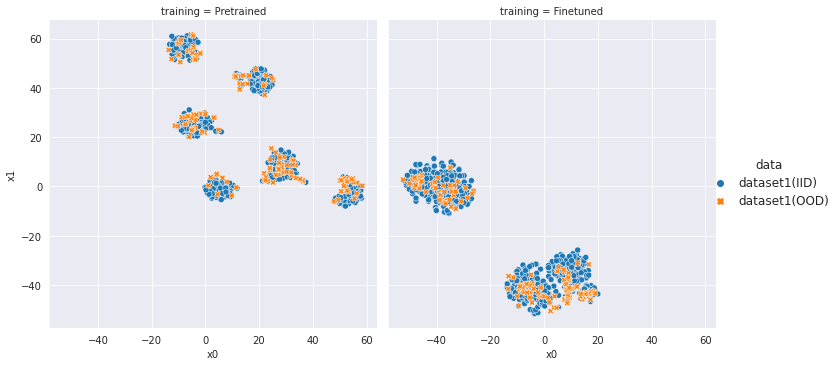

In [40]:
ax = sns.relplot(
    data=df, x="x0", y="x1",
    col="training", hue="data", style="data",
    kind="scatter"
)
plt.setp(ax._legend.get_title(), fontsize=12)
plt.setp(ax._legend.get_texts(), fontsize=12)

In [20]:
from mpl_toolkits.mplot3d import Axes3D


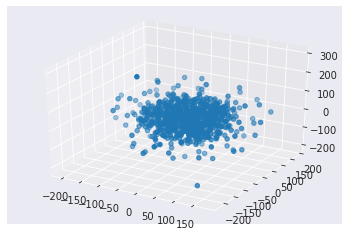

In [33]:

# df = pd.read_csv('2016.csv')
# sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

# x = df['Happiness Score']
# y = df['Economy (GDP per Capita)']
# z = df['Health (Life Expectancy)']

# ax.set_xlabel("Happiness")
# ax.set_ylabel("Economy")
# ax.set_zlabel("Health")

ax.scatter(df['x0'], df['x1'], df['x2'])

plt.show()

In [78]:
import plotly.express as px

In [79]:
# df = px.data.iris()
fig = px.scatter_3d(df, x='x0', y='x1', z='x2',
              color='data', size_max=18)
fig.show()

In [48]:
px.scatter_3d?

Signature:
px.scatter_3d(
    data_frame=None,
    x=None,
    y=None,
    z=None,
    color=None,
    symbol=None,
    size=None,
    text=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    error_z=None,
    error_z_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    size_max=None,
    color_discrete_sequence=None,
    color_discrete_map=None,
    color_continuous_scale=None,
    range_color=None,
    color_continuous_midpoint=None,
    symbol_sequence=None,
    symbol_map=None,
    opacity=None,
    log_x=False,
    log_y=False,
    log_z=False,
    range_x=None,
    range_y=None,
    range_z=None,
    title=None,
    template=None,
    width=None,
    height=None,
)
Docstring:
    In a 3D scatter plot, each row of `data_frame` is represented by a
    symbol mark in 3D space.
    
Parameters
----------
data_frame: DataFr